In [56]:
# basic packages
import pandas as pd
import os
import warnings
import pyarrow as pa
import pyarrow.parquet as pq
warnings.filterwarnings("ignore")

#Shared/Utility scripts
import torch 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from model_scripts import Simple_Eval, dataloader, dataprocessor, xgb_model #had to pip install xgboost
HOME = os.path.expanduser('~')

modelname = 'XGBoost'
model_path = f"{HOME}/SWEMLv2.0/Model/{modelname}"
if not os.path.exists(model_path):
    os.makedirs(model_path, exist_ok=True)
print(f"{modelname} development script, {device}")

XGBoost development script, cuda


In [57]:
#load data
regionlist = ['SouthernRockies', 'Southwest', 'Northwest']
output_res = '300M_Resolution'
DataFrame = 'Sturm_Seasonality_PrecipVIIRSGeoObsDFs'
fSCA_thresh = '20_fSCA_Thresh'

alldata = dataloader.get_ML_Data(regionlist, output_res, DataFrame, fSCA_thresh)
alldata.head()

Concatenating 14 for the model dataframe development.


  0%|          | 0/14 [00:00<?, ?it/s]

There are 305566 datapoints for model training/testing in the SouthernRockies modeling domain.
Concatenating 99 for the model dataframe development.


  0%|          | 0/99 [00:00<?, ?it/s]

There are 2222453 datapoints for model training/testing in the Southwest modeling domain.
Concatenating 2 for the model dataframe development.


  0%|          | 0/2 [00:00<?, ?it/s]

There are 170370 datapoints for model training/testing in the Northwest modeling domain.
There are 2698389 datapoints for model training/testing in the overall modeling domain.


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
0,29099,SouthernRockies_300M_37.001_-106.291,2015-04-06,37.001,-106.291,2871,20,72,46.2,0.0,...,0.768849,0.0,0.915969,0.680384,0.755561,0.990386,8,0.000000,SouthernRockies,1
1,19437,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.131,-106.329,3283,18,27,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.042090,SouthernRockies,1
2,19436,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.131,-106.331,3233,15,249,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000009,SouthernRockies,1
3,19435,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.131,-106.334,3266,28,232,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1
4,19434,SouthernRockies_300M_37.131_-106.337,2015-04-06,37.131,-106.337,3290,16,18,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1


## Pull out a test condition by date

In [58]:
# Pulling out 3-29-2019 in Southwest
TestArea = alldata[alldata['Date'] == '2019-03-29']
TestArea.reset_index(inplace=True, drop=True)

#remove Test area data from training/testing dataset
df = pd.concat([alldata, TestArea]).drop_duplicates(keep=False)

# Data Processing

In [59]:
#clean the data
df = dataprocessor.data_clean(df, regionlist)
df.head()

#temporary for seasonality relationship
df.fillna(1, inplace = True)

#convert dates to datetime format
df.Date = pd.to_datetime(df.Date)

input_columns = [
            'cen_lat',	
            'cen_lon',	
            'Elevation_m',	
            'Slope_Deg',	
            'Aspect_Deg',	
            'ns_1',	
            'ns_2',	
            'ns_3',	
            # 'ns_4',	
            # 'ns_5',	
            # 'ns_6',	
            'VIIRS_SCA', 
            'hasSnow',
            'season_precip_cm',
            'region_class',
            'DOS', 
            'WY_week',
            'ns_1_week_mean', 
            'ns_2_week_mean', 
            'ns_3_week_mean', 
            # 'ns_4_week_mean',
            # 'ns_5_week_mean', 
            # 'ns_6_week_mean', 
            'Seasonal_ns_1_rel',
            'Seasonal_ns_2_rel',
            'Seasonal_ns_3_rel', 
            # 'Seasonal_ns_4_rel',
            # 'Seasonal_ns_5_rel', 
            # 'Seasonal_ns_6_rel',
            'sturm_value'
]

years = False
splitratio = 0.33
test_years = [2019]
target = 'swe_cm'

#fit a scaler,save, and scale the training data
x_train, y_train, x_test, y_test = dataprocessor.xgb_processor(
                                                    regionlist,
                                                      df, 
                                                      years, 
                                                      splitratio,
                                                      test_years, 
                                                      target, 
                                                      input_columns, 
                                                      model_path, 
                                                      scalertype = 'MinMax'
                                                      )

The provided data contains 2686699 data points, of which 383243 locations/timesteps show no SWE and VIIRS fsca > 20%
274698 locations/timesteps show SWE and VIIRS fsca < 20%
0 locations/timesteps show SWE greater than a realistic value (250 cm) in the SouthernRockies domain
150 locations/timesteps show SWE greater than a realistic value (400 cm) in the Southwest domain
183 locations/timesteps show SWE greater than a realistic value (800 cm) in the Northwest domain
removing..
There are 2028575 datapoints for model training/testing.


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
0,29099,SouthernRockies_300M_37.001_-106.291,2015-04-06,37.001,-106.291,2871,20,72,46.2,0.0,...,0.768849,0.0,0.915969,0.680384,0.755561,0.990386,8,0.000000,SouthernRockies,1
1,19437,SouthernRockies_300M_37.131_-106.329,2015-04-06,37.131,-106.329,3283,18,27,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.042090,SouthernRockies,1
2,19436,SouthernRockies_300M_37.131_-106.331,2015-04-06,37.131,-106.331,3233,15,249,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000009,SouthernRockies,1
3,19435,SouthernRockies_300M_37.131_-106.334,2015-04-06,37.131,-106.334,3266,28,232,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1
4,19434,SouthernRockies_300M_37.131_-106.337,2015-04-06,37.131,-106.337,3290,16,18,46.2,0.0,...,0.768849,0.0,0.680384,0.990386,0.915969,0.603838,8,0.000000,SouthernRockies,1


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
248246,15533,Southwest_300M_37.823_-119.291,2013-04-03,37.823,-119.291,3078,20,354,21.4,51.1,...,-0.015389,-0.053034,0.895586,-0.032409,7.149647,-0.076998,8,46.415925,Southwest,2
248247,2380,Southwest_300M_38.074_-119.478,2013-04-03,38.074,-119.478,2313,37,261,75.5,113.1,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,75.392413,Southwest,2
248248,2379,Southwest_300M_38.074_-119.48,2013-04-03,38.074,-119.480,2282,25,313,75.5,113.1,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,73.140681,Southwest,2
248249,2378,Southwest_300M_38.074_-119.483,2013-04-03,38.074,-119.483,2228,28,296,75.5,113.1,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,82.782525,Southwest,2
248250,2377,Southwest_300M_38.074_-119.486,2013-04-03,38.074,-119.486,2190,27,277,75.5,113.1,...,0.791743,0.897023,-0.076998,-0.015389,-0.081448,0.000000,8,72.896212,Southwest,2


,index,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,...,Seasonal_ns_1_rel,Seasonal_ns_2_rel,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class
1889677,85184,Northwest_300M_47.496_-123.881,2016-02-08,47.496,-123.881,651,65,257,93.0,72.9,...,1.160310,1.173103,1.323113,1.516877,0.000000,2.260874,8,0.000000,Northwest,3
1889678,28390,Northwest_300M_47.892_-123.622,2016-02-08,47.892,-123.622,575,36,146,72.9,93.0,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,133.371216,Northwest,3
1889679,28391,Northwest_300M_47.892_-123.619,2016-02-08,47.892,-123.619,517,33,118,72.9,93.0,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,93.470695,Northwest,3
1889680,28392,Northwest_300M_47.892_-123.616,2016-02-08,47.892,-123.616,461,33,113,72.9,93.0,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,83.744812,Northwest,3
1889681,28393,Northwest_300M_47.892_-123.614,2016-02-08,47.892,-123.614,398,29,137,72.9,93.0,...,1.173103,1.160310,1.323113,1.046128,1.516877,2.260874,8,80.450775,Northwest,3


# Train Model

Trial Number 0 ==========================================================
Tuning hyperparametetrs on 25.0% of training data
Fitting 3 folds for each of 20 candidates, totalling 60 fits


[CV 1/3] END eta=0.1, max_depth=5, n_estimators=200;, score=-7.084 total time=  11.1s
[CV 3/3] END eta=0.1, max_depth=5, n_estimators=200;, score=-7.793 total time=  13.9s
[CV 2/3] END eta=0.1, max_depth=5, n_estimators=200;, score=-7.115 total time=  15.0s
[CV 2/3] END eta=0.1, max_depth=8, n_estimators=200;, score=-6.128 total time=  24.1s
[CV 1/3] END eta=0.1, max_depth=8, n_estimators=200;, score=-5.795 total time=  26.2s
[CV 3/3] END eta=0.1, max_depth=8, n_estimators=200;, score=-7.015 total time=  28.9s
[CV 3/3] END eta=0.1, max_depth=5, n_estimators=500;, score=-7.477 total time=  31.9s
[CV 1/3] END eta=0.1, max_depth=5, n_estimators=500;, score=-6.490 total time=  34.3s
[CV 2/3] END eta=0.1, max_depth=5, n_estimators=500;, score=-6.674 total time=  35.6s
[CV 1/3] END eta=0.1, max_depth=5, n_estimators=800;, score=-6.270 total time=  45.9s
[CV 2/3] END eta=0.1, max_depth=5, n_estimators=800;, score=-6.477 total time=  54.2s
[CV 3/3] END eta=0.1, max_depth=5, n_estimators=800;, 

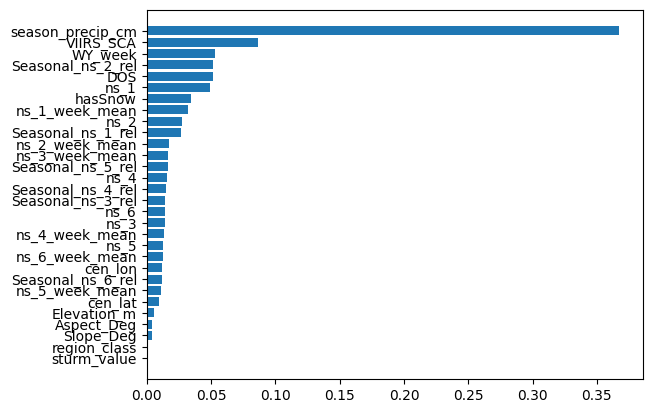

Saving Model
Run is Done!Run Time: 912.1818373203278 seconds 
Model Predictions complete
1000


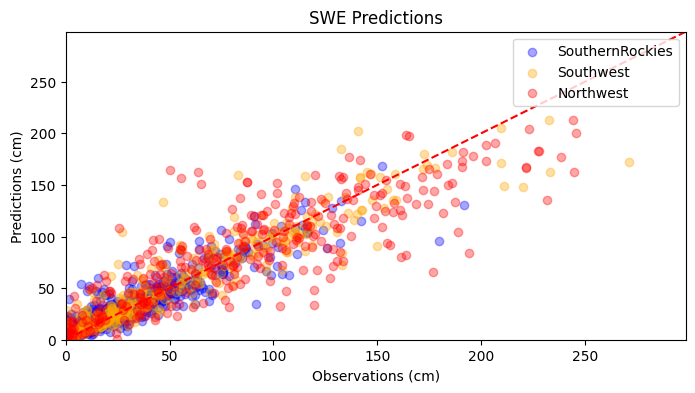

,region,XGBoost_swe_cm_kge,XGBoost_swe_cm_rmse,XGBoost_swe_cm_mape,XGBoost_swe_cm_pbias
0,Overall,0.92,13.0,53.25,-0.80
0,SouthernRockies,0.92,10.0,49.68,-2.91
0,Southwest,0.94,11.0,67.37,-2.35
0,Northwest,0.91,18.0,42.70,1.92


In [60]:
#Train model
tries = 1 #what is tries?
hyperparameters = {
    'max_depth': range (5, 16, 3),
    'n_estimators': range(200, 1700, 300),
    'eta': [0.1,]
}
perc_data = 0.25 # percent of training data used to identify optimial hyperparameters

Use_fSCA_Threshold = True

xgb_model.XGB_Train(model_path, 
                    input_columns, 
                    x_train, 
                    y_train, 
                    tries, 
                    hyperparameters,
                    perc_data)

#Make a prediction for each location, save as compressed pkl file, and send predictions to AWS for use in CSES
PredsDF = pd.DataFrame()
PredsDF = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test,
                    y_test,
                    Use_fSCA_Threshold
                    )

#Take a sample to determine model skill - Take 1000 from each modeling domain
n_samples = 1000
SampleDF, PredsDF = Simple_Eval.SamplePreds(regionlist, PredsDF, df, n_samples)

 #Evaluate model performance of the different models
prediction_columns = [f"{modelname}_swe_cm"]
Eval_DF = Simple_Eval.Simple_Eval(regionlist,
                                SampleDF,
                                prediction_columns, 
                                modelname, 
                                plots = False, 
                                keystats = False        
                                )

In [61]:
Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(PredsDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/Test_preds.parquet", compression='BROTLI')

## Make a prediction on the held out date


In [62]:

#Prep prediction data
y_test_Area = pd.DataFrame(TestArea['swe_cm'])
dropcols = ['index',	'cell_id',	'Date', 'swe_cm', 'region']
x_test_Area = TestArea.drop(columns=dropcols)
x_test_Area = x_test_Area[input_columns]

#make a prediction
holdoutdate = xgb_model.XGB_Predict(
                    model_path, 
                    modelname, 
                    x_test_Area,
                    y_test_Area,
                    Use_fSCA_Threshold
                    )
#Add geospatial information to prediction DF
EvalDF = pd.concat([TestArea, holdoutdate], axis=1)
EvalDF.drop(['index'], axis=1, inplace=True)
EvalDF = EvalDF.loc[:,~EvalDF.columns.duplicated()].copy()

EvalDF.head(5)

Model Predictions complete


,cell_id,Date,cen_lat,cen_lon,Elevation_m,Slope_Deg,Aspect_Deg,ns_1,ns_2,ns_3,...,Seasonal_ns_3_rel,Seasonal_ns_4_rel,Seasonal_ns_5_rel,Seasonal_ns_6_rel,sturm_value,swe_cm,region,region_class,ASO_swe_cm,XGBoost_swe_cm
0,Southwest_300M_37.65_-119.475,2019-03-29,37.650,-119.475,3019,65,260,122.2,103.0,145.1,...,2.358723,-0.525764,-0.046508,-0.051135,8,85.088968,Southwest,2,85.088968,139.809860
1,Southwest_300M_37.596_-119.518,2019-03-29,37.596,-119.518,2804,46,261,145.1,103.0,122.2,...,2.066611,-0.051135,-0.046508,-0.525764,8,187.475502,Southwest,2,187.475502,125.147942
2,Southwest_300M_37.772_-119.626,2019-03-29,37.772,-119.626,2316,15,352,130.4,92.4,87.0,...,-0.525764,1.821781,1.598129,1.503276,8,124.055254,Southwest,2,124.055254,136.796371
3,Southwest_300M_37.772_-119.629,2019-03-29,37.772,-119.629,2327,41,280,130.4,92.4,87.0,...,-0.525764,1.821781,1.598129,1.503276,8,138.244832,Southwest,2,138.244832,129.852432
4,Southwest_300M_37.772_-119.631,2019-03-29,37.772,-119.631,2230,34,30,130.4,92.4,87.0,...,-0.525764,1.821781,1.598129,1.503276,8,132.539642,Southwest,2,132.539642,123.494385


In [63]:
Ppath = f"{HOME}/SWEMLv2.0/Predictions/{DataFrame}/{output_res}/{fSCA_thresh}"
if not os.path.exists(Ppath):
    os.makedirs(Ppath, exist_ok=True)


#save the model predictions
table = pa.Table.from_pandas(EvalDF)
# Parquet with Brotli compression
pq.write_table(table, f"{Ppath}/All_Feats_HoldOut_03-29-2019.parquet", compression='BROTLI')

In [64]:
EvalDF.columns

Index(['cell_id', 'Date', 'cen_lat', 'cen_lon', 'Elevation_m', 'Slope_Deg',
       'Aspect_Deg', 'ns_1', 'ns_2', 'ns_3', 'ns_4', 'ns_5', 'ns_6',
       'VIIRS_SCA', 'hasSnow', 'season_precip_cm', 'DOS', 'WY_week',
       'ns_1_week_mean', 'ns_2_week_mean', 'ns_3_week_mean', 'ns_4_week_mean',
       'ns_5_week_mean', 'ns_6_week_mean', 'Seasonal_ns_1_rel',
       'Seasonal_ns_2_rel', 'Seasonal_ns_3_rel', 'Seasonal_ns_4_rel',
       'Seasonal_ns_5_rel', 'Seasonal_ns_6_rel', 'sturm_value', 'swe_cm',
       'region', 'region_class', 'ASO_swe_cm', 'XGBoost_swe_cm'],
      dtype='object')